## 一、低价因子 - 单边检验（做多第一组）
### 1.设置因子验证参数：开始时间、截止时间、低价因子、再平衡周期、分组数量

In [12]:
import json
from datetime import datetime
import pandas as pd
from util.util import write_file


# 开始时间
start_date = "2021-01-01"
# 截止时间
end_date = "2021-12-31"
# 因子
factor = 'Price'

# 再平衡周期(20个交易日)
adjust_days = 20
# 分组数量
group_num = 10



### 2.循环执行，在每个再平衡日，执行调仓：按低价因子选股、买入卖出、计算收益

In [13]:
# 所有的交易日
df = pd.read_csv("data/trade_dates.csv")
# 从开始日期到截止日期，期间所有的交易日
pattern = (df['date']>=start_date) & (df['date']<=end_date)  
trade_dates = list(df[pattern]['date'])

# 加载所有上市股票数据
static = pd.read_csv("data/stock_static.csv")
# 加载个股是否ST数据
extra = pd.read_csv("data/extra.csv")

# 所有的再平衡日
days = len(trade_dates)
adjust_dates = [trade_dates[i] for i in range(0, days) if (i%adjust_days ==0) or (i == days-1)]


In [ ]:
# 因子排序
sort = "ascending"
# 所有再平衡日的收益率
adjust_profit_ratios = []
# 初始净值
net_value = 1
# 持仓股列表
holding_stocks = []
# 每一期的股票池
adjust_stock_pools = []

# 持久化文件
log_file = 'log/{}-{}_过滤ST和新股.log'.format(factor, sort)
# 输出运行参数
msg = {"start_date":start_date, "end_date":end_date, "factor":factor, "sort": sort, "adjust_days":adjust_days, "group_num":group_num}
print("{} >> run params:{}".format(datetime.now(), msg))
write_file(log_file, "{} >> start param:{}".format(datetime.now(), msg), append=False)

for today in adjust_dates:
    print("{} >> run at : {}".format(datetime.now(), today))
    write_file(log_file, "{} >> run at : {}".format(datetime.now(), today), append=True)
    # 当日所有还在上市的股票
    df = static[(static['start_date']<=today)&(static['end_date']>=today)]
    trade_stocks = list(df['code'])

    # 加载行情数据： 当日所有个股的行情数据
    stock_daily_dict = {}
    df = pd.read_csv("data/daily/{}.csv".format(today.replace("-","")))
    for idx, row in df.iterrows():
        code = row['code']
        stock_daily_dict[code] = row.to_dict()

    # 加载个股ST数据
    daily_extra = extra[extra['date'] == today]
    write_file(log_file, "loading data success: {}".format(today), append=True)

    # 计算当期收益率
    stock_profit_ratios = []
    for stock in holding_stocks:
        ## 计算所有持仓股收益率
        code = stock['code']
        # 加载当日行情
        daily =  stock_daily_dict.get(code, None)
        if daily is None:
            # 持仓股已经退市,查询不到当日的价格。查询退市前最后一个交易日的行情
            df = pd.read_csv("data/daily/{}.csv".format(code))
            daily = df[df['date'] <= today].iloc[-1].to_dict()
        # 计算个股收益率: 收盘价前复权 /买入价 - 1
        ratio = daily['pre_fq_close']/stock['buy_price'] -1
        stock_profit_ratios.append(ratio)

        # 计算个股收益：输出到日志文件
        msg = {"date": today, "code":code,
               "buy_date":stock['buy_date'],"buy_price":stock["buy_price"],
               "sell_date":today, "sell_price":daily['pre_fq_close'], "profit": ratio}
        write_file(log_file, "calc_stock_profit : {}".format(msg), append=True)

    # 当前收益率
    issue_profit_ratio = 0 if len(stock_profit_ratios)==0 else sum(stock_profit_ratios)/len(stock_profit_ratios)
    net_value = net_value *(1+issue_profit_ratio)
    # total_profit_ratio： 从回测开始截止到当期的累计收益
    issue_info = {"date": today, 'net_value': net_value, "total_profit_ratio": net_value -1, "issue_profit_ratio": issue_profit_ratio}
    adjust_profit_ratios.append(issue_info)
    write_file(log_file, "calc profit : {}".format(issue_info), append=True)

    # 跌停或停牌无法卖出的持仓股
    write_file(log_file, "run sell: {}".format(today), append=True)
    not_sold_stocks = []
    for stock in holding_stocks:
        code = stock['code']
        # 加载当日行情
        daily =  stock_daily_dict.get(code, None)
        # 剔除持仓期间已经退市的股票
        if daily and (daily['paused']>0 or daily['low']<=daily['low_limit']):
                not_sold_stocks.append(code)
                adjust_stock_pools.append({'date':today, 'code': code, factor: 'not sold'})
                write_file(log_file, "not sold, paused or drop limit: {}".format(code), append=True)



    # 筛选出符合条件的股票: 根据价格（不复权）排序后
    write_file(log_file, "run stock_pool: {}".format(today), append=True)
    selected_stocks = []
    for code in trade_stocks:
        # 过滤掉已入选股票池的股票（持仓股中没有卖出的个股）
        if code in not_sold_stocks:
            write_file(log_file, "filter out holding stock: {}".format(code), append=True)
            continue

        # 过滤掉ST
        is_st = daily_extra[daily_extra['code'] == code].iloc[0]['is_st']
        if is_st:
            write_file(log_file, "filter out st: {}".format(code), append=True)
            continue

        # 过滤掉新股: 上市不满一年
        stock_static = static[static['code'] == code].iloc[0]
        listed_date = datetime.strptime(stock_static['start_date'], "%Y-%m-%d")
        listed_days = (datetime.strptime(today, "%Y-%m-%d") - listed_date).days
        if listed_days <= 365:
            write_file(log_file, "filter out new stock: {}".format(code), append=True)
            continue

        daily = stock_daily_dict.get(code)
        # 过滤：停牌/涨停股票
        if daily['paused'] > 0 or daily['high'] >= daily['high_limit']:
            write_file(log_file, "filter out, paused or rise limit: {}".format(code), append=True)
            continue
        selected_stocks.append({'date':today, 'code': code, factor: daily['close']})


    # 因子排序
    reverse = False if sort == "ascending" else True
    selected_stocks = sorted(selected_stocks, key=lambda x: x[factor], reverse=reverse)

    # 需要从候选股票中补齐的数量
    group_size = int(len(trade_stocks)/group_num)
    not_sold_number = len(not_sold_stocks)
    selected_number = group_size - not_sold_number
    # 筛选出第一组
    selected_stocks = selected_stocks[:selected_number]
    adjust_stock_pools+= selected_stocks

    # 当前股票池
    issue_stock_pool = not_sold_stocks +  [c['code'] for c in selected_stocks]

    # 清空持仓列表
    holding_stocks = []
    # 加载入选股收盘价（前复权），以收盘价买入。
    for code in issue_stock_pool:
        daily = stock_daily_dict[code]
        holding_stocks.append({"code": code, "buy_price": daily['pre_fq_close'], "buy_date": today})

df = pd.DataFrame(adjust_stock_pools)
write_file("log/{}-{}_过滤ST和新股-stock_pool.csv".format(factor, sort), df.to_csv(index=False), append=False)

profit = pd.DataFrame(adjust_profit_ratios)
profit.set_index('date', inplace=True)
write_file("log/{}-{}_过滤ST和新股-profit.csv".format(factor, sort), profit.to_csv(), append=False)



2022-10-22 14:34:22.659238 >> run params:{'start_date': '2021-01-01', 'end_date': '2021-12-31', 'factor': 'Price', 'sort': 'ascending', 'adjust_days': 20, 'group_num': 10}
2022-10-22 14:34:22.661261 >> run at : 2021-01-04
2022-10-22 14:34:28.260672 >> run at : 2021-02-01
2022-10-22 14:34:34.308353 >> run at : 2021-03-08
2022-10-22 14:34:39.814077 >> run at : 2021-04-06
2022-10-22 14:34:45.531052 >> run at : 2021-05-07
2022-10-22 14:34:51.749906 >> run at : 2021-06-04
2022-10-22 14:34:58.039497 >> run at : 2021-07-05
2022-10-22 14:35:04.243033 >> run at : 2021-08-02
2022-10-22 14:35:10.165605 >> run at : 2021-08-30
2022-10-22 14:35:16.572944 >> run at : 2021-09-29
2022-10-22 14:35:22.963853 >> run at : 2021-11-03


In [ ]:
### 3.画图

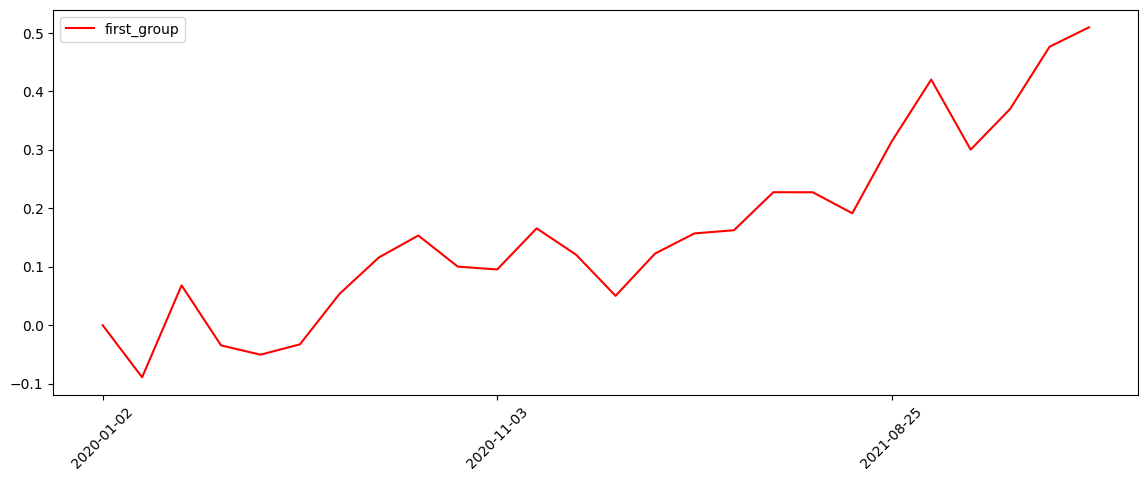

In [7]:
import matplotlib.pyplot as plt
import numpy as np


#设置画布大小
plt.figure(figsize=(14,5))
#设置X轴
# 显示的刻度有重叠，抽样显示刻度：X轴刻度的索引号
x_ticks = np.arange(0, len(profit), 10)
# #设置X轴刻度
plt.xticks(x_ticks, rotation=45)
## 设置X轴数值
x = list(profit.index)
# 画图
plt.plot(x,list(profit['total_profit_ratio']),color='r',label='first_group')
plt.legend(['first_group'])

##  二、低价因子 - 零投资组合检验（做多第一组，做空最后一组）

### 1. 循环执行：在每个再平衡周期，选取第一组,  执行调仓操作

In [8]:
# 直接引用- 单边检验中已经执行的结果
first_group = profit

### 2.循环执行：在每个再平衡周期，选取最后一组, 执行调仓操作

In [9]:
# 因子排序
sort = "descending"
# 所有再平衡日的收益率
adjust_profit_ratios = []
# 初始净值
net_value = 1
# 持仓股列表
holding_stocks = []
# 每一期的股票池
adjust_stock_pools = []

# 持久化文件
log_file = 'log/{}-{}.log'.format(factor, sort)
# 输出运行参数
msg = {"start_date":start_date, "end_date":end_date, "factor":factor, "sort": sort, "adjust_days":adjust_days, "group_num":group_num}
print("{} >> run params:{}".format(datetime.now(), msg))
write_file(log_file, "{} >> start param:{}".format(datetime.now(), msg), append=False)

for today in adjust_dates:
    print("{} >> run at : {}".format(datetime.now(), today))
    write_file(log_file, "{} >> run at : {}".format(datetime.now(), today), append=True)
    # 当日所有还在上市的股票
    df = static[(static['start_date']<=today)&(static['end_date']>=today)]
    trade_stocks = list(df['code'])

    # 加载行情数据： 当日所有个股的行情数据
    stock_daily_dict = {}
    df = pd.read_csv("data/daily/{}.csv".format(today.replace("-","")))
    for idx, row in df.iterrows():
        code = row['code']
        stock_daily_dict[code] = row.to_dict()

    # 加载个股ST数据
    daily_extra = extra[extra['date'] == today]
    write_file(log_file, "loading data success: {}".format(today), append=True)

    # 计算当期收益率
    stock_profit_ratios = []
    for stock in holding_stocks:
        ## 计算所有持仓股收益率
        code = stock['code']
        # 加载当日行情
        daily =  stock_daily_dict.get(code, None)
        if daily is None:
            # 持仓股已经退市,查询不到当日的价格。查询退市前最后一个交易日的行情
            df = pd.read_csv("data/daily/{}.csv".format(code))
            daily = df[df['date'] <= today].iloc[-1].to_dict()
        # 计算个股收益率: 收盘价前复权 /买入价 - 1
        ratio = daily['pre_fq_close']/stock['buy_price'] -1
        stock_profit_ratios.append(ratio)

        # 计算个股收益：输出到日志文件
        msg = {"date": today, "code":code,
               "buy_date":stock['buy_date'],"buy_price":stock["buy_price"],
               "sell_date":today, "sell_price":daily['pre_fq_close'], "profit": ratio}
        write_file(log_file, "calc_stock_profit : {}".format(msg), append=True)

    # 当前收益率
    issue_profit_ratio = 0 if len(stock_profit_ratios)==0 else sum(stock_profit_ratios)/len(stock_profit_ratios)
    net_value = net_value *(1+issue_profit_ratio)
    # total_profit_ratio： 从回测开始截止到当期的累计收益
    issue_info = {"date": today, 'net_value': net_value, "total_profit_ratio": net_value -1, "issue_profit_ratio": issue_profit_ratio}
    adjust_profit_ratios.append(issue_info)
    write_file(log_file, "calc profit : {}".format(issue_info), append=True)

    # 跌停或停牌无法卖出的持仓股
    write_file(log_file, "run sell: {}".format(today), append=True)
    not_sold_stocks = []
    for stock in holding_stocks:
        code = stock['code']
        # 加载当日行情
        daily =  stock_daily_dict.get(code, None)
        # 剔除持仓期间已经退市的股票
        if daily and (daily['paused']>0 or daily['low']<=daily['low_limit']):
                not_sold_stocks.append(code)
                adjust_stock_pools.append({'date':today, 'code': code, factor: 'not sold'})
                write_file(log_file, "not sold, paused or drop limit: {}".format(code), append=True)



    # 筛选出符合条件的股票: 根据价格（不复权）排序后
    write_file(log_file, "run stock_pool: {}".format(today), append=True)
    selected_stocks = []
    for code in trade_stocks:
        # 过滤掉已入选股票池的股票（持仓股中没有卖出的个股）
        if code in not_sold_stocks:
            write_file(log_file, "filter out holding stock: {}".format(code), append=True)
            continue

        # 过滤掉ST
        is_st = daily_extra[daily_extra['code'] == code].iloc[0]['is_st']
        if is_st:
            write_file(log_file, "filter out st: {}".format(code), append=True)
            continue

        # 过滤掉新股: 上市不满一年
        stock_static = static[static['code'] == code].iloc[0]
        listed_date = datetime.strptime(stock_static['start_date'], "%Y-%m-%d")
        listed_days = (datetime.strptime(today, "%Y-%m-%d") - listed_date).days
        if listed_days <= 365:
            write_file(log_file, "filter out new stock: {}".format(code), append=True)
            continue

        daily = stock_daily_dict.get(code)
        # 过滤：停牌/涨停股票
        if daily['paused'] > 0 or daily['high'] >= daily['high_limit']:
            write_file(log_file, "filter out, paused or rise limit: {}".format(code), append=True)
            continue
        selected_stocks.append({'date':today, 'code': code, factor: daily['close']})


    # 因子排序
    reverse = False if sort == "ascending" else True
    selected_stocks = sorted(selected_stocks, key=lambda x: x[factor], reverse=reverse)

    # 需要从候选股票中补齐的数量
    group_size = int(len(trade_stocks)/group_num)
    not_sold_number = len(not_sold_stocks)
    selected_number = group_size - not_sold_number
    # 筛选出第一组
    selected_stocks = selected_stocks[:selected_number]
    adjust_stock_pools+= selected_stocks

    # 当前股票池
    issue_stock_pool = not_sold_stocks +  [c['code'] for c in selected_stocks]

    # 清空持仓列表
    holding_stocks = []
    # 加载入选股收盘价（前复权），以收盘价买入。
    for code in issue_stock_pool:
        daily = stock_daily_dict[code]
        holding_stocks.append({"code": code, "buy_price": daily['pre_fq_close'], "buy_date": today})

df = pd.DataFrame(adjust_stock_pools)
write_file("log/{}-{}-stock_pool.csv".format(factor, sort), df.to_csv(index=False), append=False)

profit = pd.DataFrame(adjust_profit_ratios)
profit.set_index('date', inplace=True)
write_file("log/{}-{}-profit.csv".format(factor, sort), profit.to_csv(), append=False)

2022-10-22 14:06:00.812988 >> run params:{'start_date': '2020-01-01', 'end_date': '2021-12-31', 'factor': 'Price', 'sort': 'descending', 'adjust_days': 20, 'group_num': 10}
2022-10-22 14:06:00.814988 >> run at : 2020-01-02
2022-10-22 14:06:03.565778 >> run at : 2020-02-07
2022-10-22 14:06:06.491267 >> run at : 2020-03-06
2022-10-22 14:06:09.506380 >> run at : 2020-04-03
2022-10-22 14:06:12.516419 >> run at : 2020-05-07
2022-10-22 14:06:15.626837 >> run at : 2020-06-04
2022-10-22 14:06:18.682606 >> run at : 2020-07-06
2022-10-22 14:06:21.826749 >> run at : 2020-08-03
2022-10-22 14:06:25.119091 >> run at : 2020-08-31
2022-10-22 14:06:28.305691 >> run at : 2020-09-28
2022-10-22 14:06:31.624994 >> run at : 2020-11-03
2022-10-22 14:06:34.943350 >> run at : 2020-12-01
2022-10-22 14:06:38.259458 >> run at : 2020-12-29
2022-10-22 14:06:41.657644 >> run at : 2021-01-27
2022-10-22 14:06:45.115792 >> run at : 2021-03-03
2022-10-22 14:06:48.613112 >> run at : 2021-03-31
2022-10-22 14:06:52.108106 

In [10]:
last_group = profit

### 3. 画图

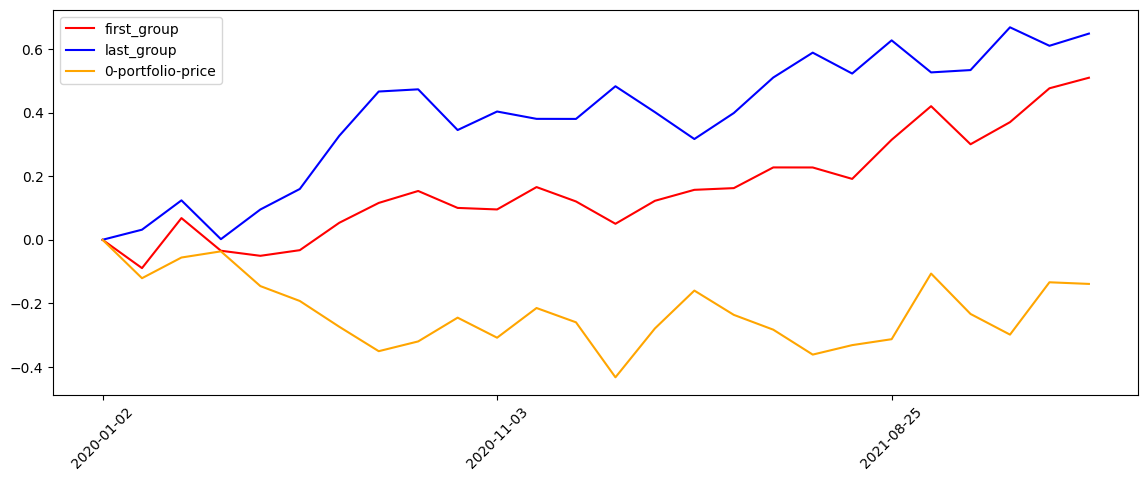

In [11]:
import matplotlib.pyplot as plt
import numpy as np

#设置画布大小
plt.figure(figsize=(14,5))
#设置X轴
# 如果显示的刻度有重叠，可以抽样显示刻度：X轴刻度的索引号
x_ticks = np.arange(0, len(last_group), 10)
# #设置X轴刻度
plt.xticks(x_ticks, rotation=45)
## 设置X轴数值
x = list(last_group.index)

# 画图
plt.plot(x,list(first_group['total_profit_ratio']),color='r',label='first_group')
plt.plot(x,list(last_group['total_profit_ratio']),color='b',label='last_group')
plt.plot(x,list(first_group['total_profit_ratio'] - last_group['total_profit_ratio']),color='orange',label='0-portfolio-price')
plt.legend(['first_group','last_group','0-portfolio-price'])